In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))

In [2]:
# No issue with this code

In [3]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from algorithm import *
from explainer import *
from genetic import *
import dalex as dx
from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
data = pd.read_csv('../../../Dataset/cybersecurity_intrusion_data.csv')
# data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'responh'])
has_failed_logins = []
for i in data['failed_logins']:
    if i:
        has_failed_logins.append(1)
    else:
        has_failed_logins.append(0)

data['has_failed_logins'] = has_failed_logins
data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})
data['attack_detected'] = data['attack_detected'].replace({0: 1, 1: 0})
data.head()

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,has_failed_logins
0,SID_00001,599,1,4,492.983263,1.0,0.606818,1,Edge,0,0,1
1,SID_00002,472,1,3,1557.996461,1.0,0.301569,0,Firefox,0,1,0
2,SID_00003,629,1,3,75.044262,1.0,0.739164,2,Chrome,0,0,1
3,SID_00004,804,2,4,601.248835,1.0,0.123267,0,Unknown,0,0,0
4,SID_00005,453,1,5,532.540888,0.0,0.054874,1,Firefox,0,1,1


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1.0,0.606818,1,0,0,1
1,472,1,3,1557.996461,1.0,0.301569,0,0,1,0
2,629,1,3,75.044262,1.0,0.739164,2,0,0,1
3,804,2,4,601.248835,1.0,0.123267,0,0,0,0
4,453,1,5,532.540888,0.0,0.054874,1,0,1,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   int64  
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      7571 non-null   float64
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   unusual_time_access  9537 non-null   int64  
 8   attack_detected      9537 non-null   int64  
 9   has_failed_logins    9537 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 745.2 KB


In [7]:
data = data.dropna(axis=1)

In [8]:
protected_feature = 'has_failed_logins'

In [9]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='attack_detected',
        protected_feature=protected_feature,
        do_scaling=True,
        scale_all_features=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling ALL numerical features as requested (scale_all_features=True).
Features actually being scaled: ['network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access', 'has_failed_logins']


In [10]:
print(len(x_train.columns))
x_train.head()

8


,network_packet_size,protocol_type,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,has_failed_logins
4521,1.070864,-0.391379,1.484552,-0.300794,-0.038904,0.461359,-0.41557,0.441533
8445,-0.860225,-0.391379,2.492526,-0.940790,-1.298406,0.461359,-0.41557,0.441533
9438,0.825089,1.530956,1.988539,-0.342331,-1.479774,0.461359,-0.41557,0.441533
2357,0.137923,-0.391379,0.476579,0.587420,0.025405,-0.507364,-0.41557,0.441533
5798,0.509093,-0.391379,-0.531395,-0.324137,-0.488635,-0.507364,-0.41557,0.441533


In [11]:
feature_names

['network_packet_size',
 'protocol_type',
 'login_attempts',
 'session_duration',
 'ip_reputation_score',
 'failed_logins',
 'unusual_time_access',
 'has_failed_logins']

In [12]:

# Define VARIABLES_TO_CHANGE using the original column names
VARIABLES_TO_CHANGE = ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins']

# Define the full list of columns you want to select for your features
all_feature_other_than_protected = set(x_train.columns)
all_feature_other_than_protected.remove(protected_feature)
selected_columns = [protected_feature] + list(all_feature_other_than_protected-set(VARIABLES_TO_CHANGE)) + VARIABLES_TO_CHANGE

# Apply the column selection to X_train and X_test
x_train = x_train.loc[:, selected_columns]
x_test = x_test.loc[:, selected_columns]

# y_train and y_test remain unchanged as they already contain the target variable

Accuracy: 0.7470300489168413
Precision: 0.7481225800000119
Recall: 0.7470300489168413
F-1: 0.7442507031981037


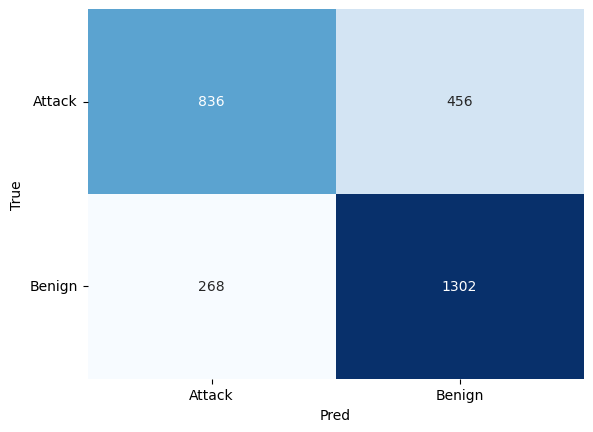

In [13]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [14]:
explainer = Explainer(model, x_test, 'l')

In [15]:
e = dx.Explainer(model, x_test, y_test, verbose=False)
e.model_performance()

,recall,precision,f1,accuracy,auc
LogisticRegression,0.829299,0.740614,0.782452,0.74703,0.806537


In [16]:
# pd.DataFrame({'variable': x_train.columns, 'importance_split': model.feature_importances_,
#               'importance_shap': explainer.shap_values(explainer.data),
#               'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})


In [17]:
y_test = list(y_test)

In [18]:
I = 7
for i in range(len(y_test)):
    if y_test[i]==0:
        I=i
        break
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I)
e.data.iloc[[I]].assign(y=e.y[[I]], y_hat=e.y_hat[[I]])

,has_failed_logins,unusual_time_access,protocol_type,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,y,y_hat
1824,0.441533,-0.41557,-0.391379,0.163002,-0.027408,0.257462,1.54642,0.461359,0,0.268111


In [19]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X, a._x)
t = np.array([i + (max(t) / (len(t) - 3)) if i > 0 else i - (t[0] / (len(t) - 3)) for i in t])
t[0] = -0.005
print(list(a.explainer.shap_values(a._X, a._x)).index(max(list(a.explainer.shap_values(a._X, a._x)))))
t[list(a.explainer.shap_values(a._X, a._x)).index(max(list(a.explainer.shap_values(a._X, a._x))))] = min(0.1, t[list(a.explainer.shap_values(a._X, a._x)).index(max(list(a.explainer.shap_values(a._X, a._x))))])
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X, a._x), 'target': t})

7


,variable,shap_values,target
0,has_failed_logins,0.496265,-0.005000
1,unusual_time_access,0.024160,0.277768
2,protocol_type,0.002164,0.255772
3,network_packet_size,0.015636,0.269244
4,login_attempts,0.617977,0.871585
5,session_duration,0.068080,0.321688
6,ip_reputation_score,0.475824,0.729431
7,failed_logins,1.268038,0.100000


In [20]:
a.fool_aim(target=t, max_iter=200, random_state=0)

Iter: 200 || Loss: 0.7365338640797845: 100%|██████████| 200/200 [42:09<00:00, 12.65s/it]


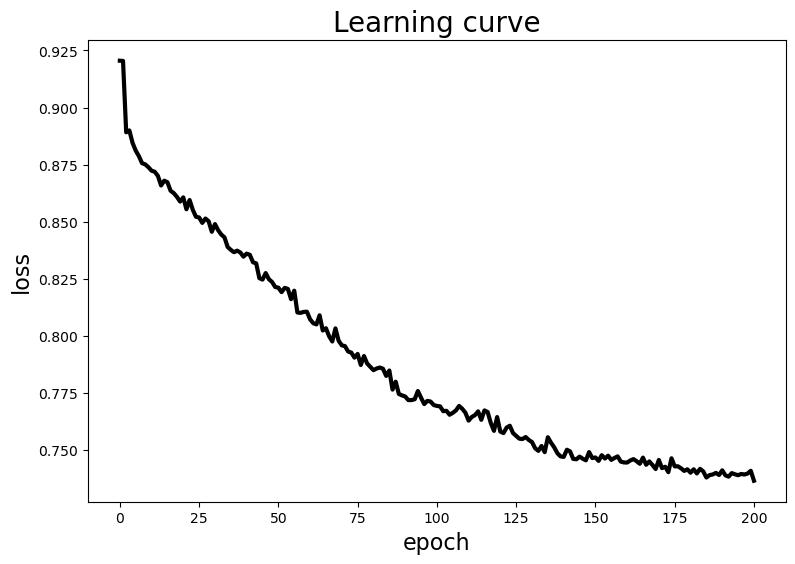

In [21]:
a.plot_losses()

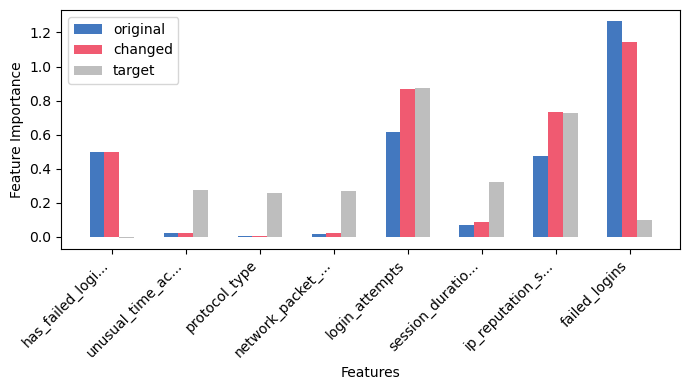

In [22]:
a.plot_explanation()

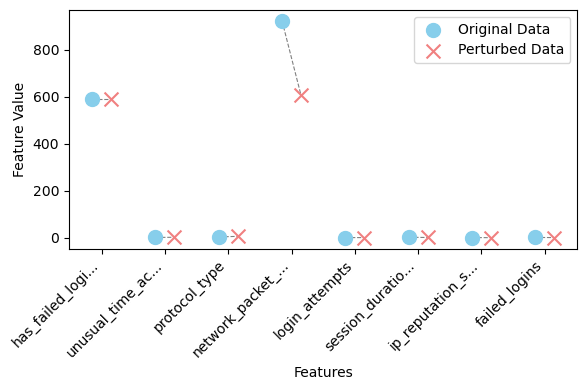

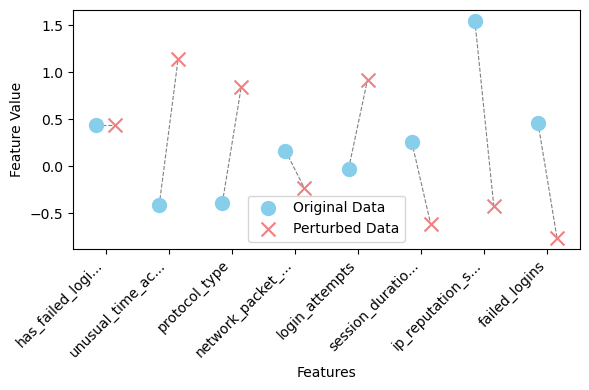

In [25]:
a.plot_data(scaler=scaler, numerical_features_scaled=VARIABLES_TO_CHANGE)
a.plot_data()

In [24]:
a.display_feature_rank_changes()


--- Feature Ranking Changes ---

Ranking Changes: Original vs. Changed Explanation
--------------------------------------------------
Feature 'has_failed_logins': Rank changed from 3 to 4
Feature 'ip_reputation_score': Rank changed from 4 to 3

Table Summary (Original vs. Changed):
            Feature  Rank_Original  Rank_Changed
  has_failed_logins              3             4
ip_reputation_score              4             3


Ranking Changes: Original vs. Target Explanation
--------------------------------------------------
Feature 'failed_logins': Rank changed from 1 to 7
Feature 'login_attempts': Rank changed from 2 to 1
Feature 'has_failed_logins': Rank changed from 3 to 8
Feature 'ip_reputation_score': Rank changed from 4 to 2
Feature 'session_duration': Rank changed from 5 to 3
Feature 'unusual_time_access': Rank changed from 6 to 4
Feature 'network_packet_size': Rank changed from 7 to 5
Feature 'protocol_type': Rank changed from 8 to 6

Table Summary (Original vs. Target):
   